In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import networkx as nx
import torch
from torch_geometric.data import Data

ModuleNotFoundError: No module named 'torch_geometric'

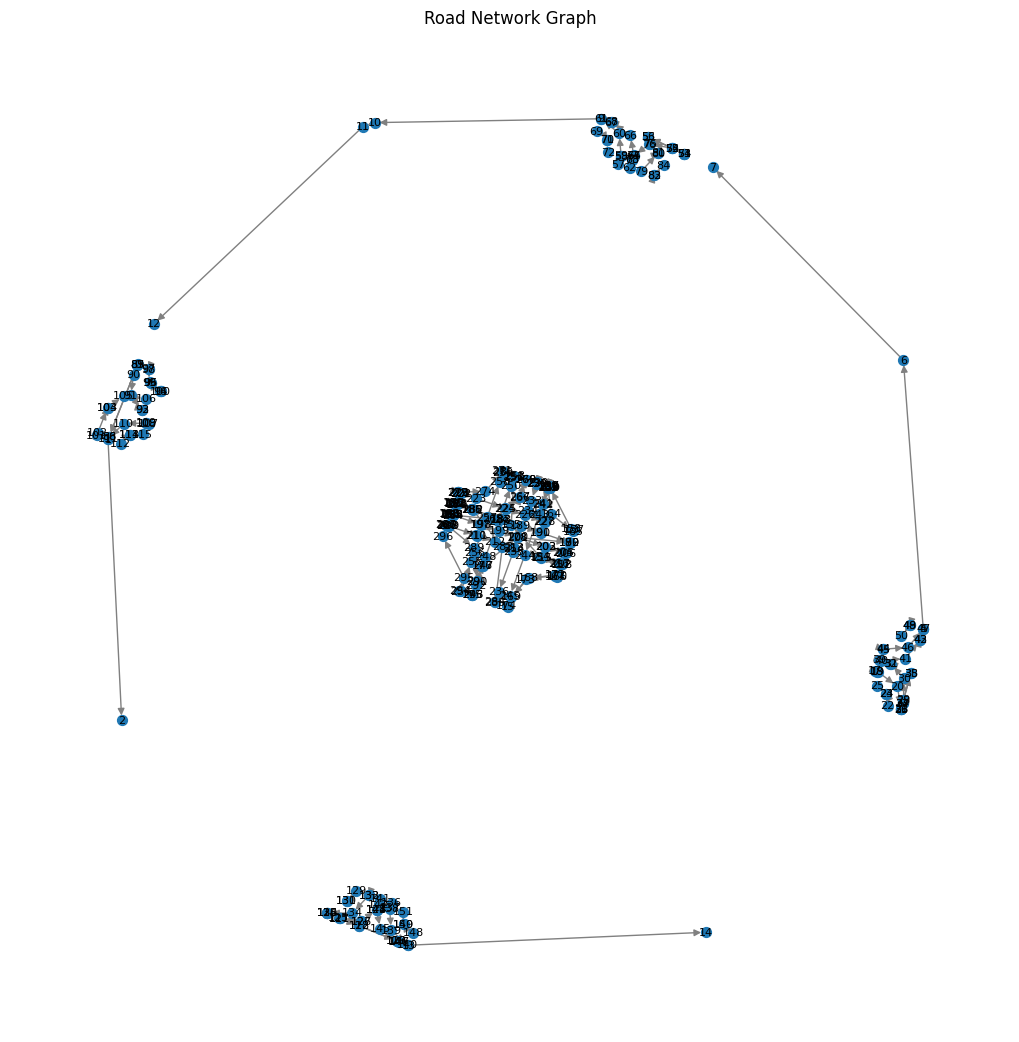

Data(x=[297, 3], edge_index=[2, 236], edge_attr=[236, 1])


In [3]:


def parse_xodr(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    G = nx.DiGraph()
    node_id = 0
    node_map = {}
    
    for road in root.findall("road"):
        road_id = road.get("id")
        length = float(road.get("length"))
        speed_limit = None
        
        road_type = road.find("type")
        if road_type is not None:
            speed_element = road_type.find("speed")
            if speed_element is not None:
                speed_limit = float(speed_element.get("max"))
        
        planView = road.find("planView")
        prev_node = None
        
        for geometry in planView.findall("geometry"):
            x = float(geometry.get("x"))
            y = float(geometry.get("y"))
            hdg = float(geometry.get("hdg"))
            geom_length = float(geometry.get("length"))
            
            node_map[node_id] = (x, y)
            G.add_node(node_id, x=x, y=y, road_id=road_id, speed_limit=speed_limit)
            
            if prev_node is not None:
                G.add_edge(prev_node, node_id, length=geom_length)
            
            prev_node = node_id
            node_id += 1
    
    return G, node_map

def convert_to_pyg_data(G):
    node_features = []
    edge_index = []
    edge_features = []
    
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    
    for node in G.nodes(data=True):
        node_features.append([node[1].get("x", 0), node[1].get("y", 0), node[1].get("speed_limit", 0)])
    
    for edge in G.edges(data=True):
        edge_index.append([node_mapping[edge[0]], node_mapping[edge[1]]])
        edge_features.append([edge[2].get("length", 0)])
    
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_features = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)

def plot_graph(G, node_map):
    plt.figure(figsize=(10, 10))
    pos = {node: (node_map[node][0], node_map[node][1]) for node in G.nodes()}
    nx.draw(G, pos, node_size=50, with_labels=True, font_size=8, edge_color="gray")
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title("Road Network Graph")
    plt.grid()
    plt.show()

# Load and process the OpenDRIVE file
xodr_file = "data/4way.xodr"  # Replace with your actual file path
G, node_map = parse_xodr(xodr_file)
plot_graph(G, node_map)

graph_data = convert_to_pyg_data(G)
print(graph_data)


/home/rajnish/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


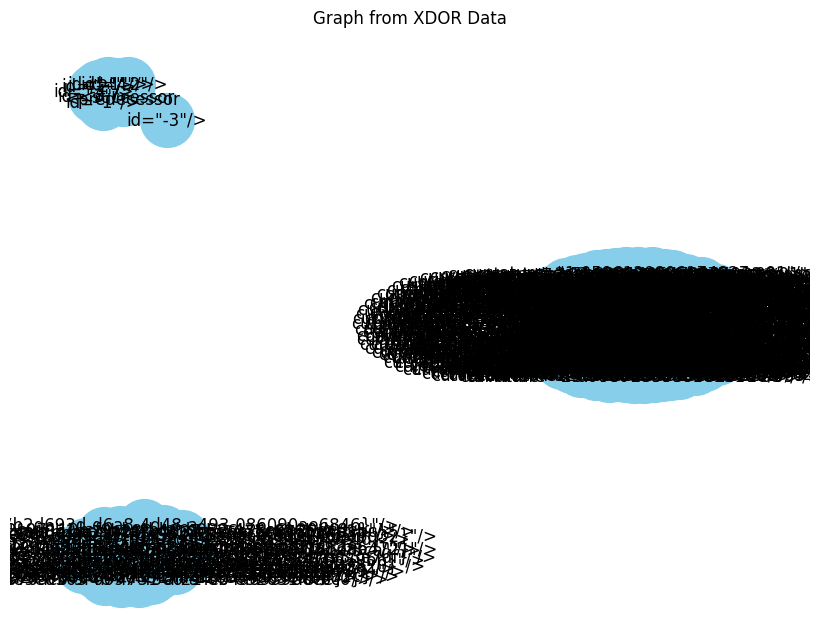

In [2]:
torch.cuda.is_available()

True